# Reinforcement learning
Reinforcement learning on the pyworld3 model. The goal is to get a reinforcement learning agent to improve upon the standard run and thens tudy what controls were implemented for the improved run. With improving on the standard run we mean that one aspect of it performs better according to some predefined reward function. \
Training data can be obtained by running data_generation.py

In [16]:
import numpy as np
from pyworld3 import World3
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

In [27]:
max_year = 2100
world_reference = World3(year_max=max_year)
world_reference.set_world3_control()
world_reference.init_world3_constants()
world_reference.init_world3_variables()
world_reference.set_world3_table_functions()
world_reference.set_world3_delay_functions()
world_reference.run_world3(fast=True)


def reward_HDI(world, k=None):

    # le: life expactancy [years], want a high value
    # j/pop: determine unemployment, a high value is seeked and would simule a low global unemployment
    # sopc: service output per capital [dollars/person-year], will substitute for GNP


    # Collect max/min values

    # le  
    min_le = np.min(world_reference.le) * 0.95
    max_le = np.max(world_reference.le) * 1.05
    I_le = (world.le - min_le) / (max_le - min_le)
    I_le = np.clip(I_le, 0, 1)      # keeps the index between 0 and 1

    # j/pop
    ref_jpop = world_reference.j / world_reference.pop
    min_jpop = np.min(ref_jpop) * 0.95
    max_jpop = np.max(ref_jpop) * 1.05
    # max_jpop = 1
    jpop = world.j/world.pop
    I_jpop = (jpop - min_jpop) / (max_jpop - min_jpop)
    I_jpop = np.clip(I_jpop, 0, 1)

    # sopc
    min_gdp = np.min(world_reference.sopc + world_reference.iopc)*0.95 #minska extremfall
    max_gdp = np.max(world_reference.sopc + world_reference.iopc)*1.05 #minska extremfall
    world_gdp = world.sopc + world.iopc
    I_gdp = (world_gdp - min_gdp) / (max_gdp - min_gdp)
    I_gdp = np.clip(world_gdp, 0, 1)


    # Create HDI
    reward = (I_le * I_jpop * I_gdp)**(1/3)
    if k is None:
        return reward
    else: 
        return reward[k]

def reward_HSDI(world, k=None):
    # le: life expectancy
    # j/pop: determine unemployment, a high value is seeked and would simule a low global unemployment, will substitute for education
    # sopc: service output per capital [dollars/person-year], will substitute for GNP
    # ppol/pop: persistent pollution per capita

        # le
    min_le = np.min(world_reference.le) * 0.95
    max_le = np.max(world_reference.le) * 1.05
    I_le = (world.le - min_le) / (max_le - min_le)
    I_le = np.clip(I_le, 0, 1)      # keeps the index between 0 and 1

    # j/pop
    ref_jpop = world_reference.j / world_reference.pop
    min_jpop = np.min(ref_jpop) * 0.95
    max_jpop = np.max(ref_jpop) * 1.05
    # max_jpop = 1
    jpop = world.j/world.pop
    I_jpop = (jpop - min_jpop) / (max_jpop - min_jpop)
    I_jpop = np.clip(I_jpop, 0, 1)

    # gdp - calculated as service output + industrial output
    min_gdp = np.min(world_reference.sopc + world_reference.iopc)*0.95 #minska extremfall
    max_gdp = np.max(world_reference.sopc + world_reference.iopc)*1.05 #minska extremfall
    world_gdp = world.sopc + world.iopc
    I_gdp = (world_gdp - min_gdp) / (max_gdp - min_gdp)
    I_gdp = np.clip(world_gdp, 0, 1)

    # pollution per capita
    min_ppol_pop = np.min(world_reference.ppol / world_reference.pop)*0.95
    max_ppol_pop = np.max(world_reference.ppol / world_reference.pop)*1.05  #för att minimera extremvärden
    ppol_pop = world.ppol / world.pop
    # ppol_pop = np.clip(ppol_pop, 0, 1) # ska detta verkligen göras här?
    I_ppol_pop = 1 - ((ppol_pop - min_ppol_pop) / (max_ppol_pop - min_ppol_pop))
    I_ppol_pop = np.clip(I_ppol_pop, 0, 1)

    # HSDI
    reward = (I_le * I_jpop * I_gdp * I_ppol_pop) ** (1/4)
    if k is None:
        return reward
    else: 
        return reward[k]

## Data extraction and training of neural net
This assumes that there is some file with rewards J and states stored for randomized runs.

In [28]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

max_year = 2100
filepath = "datasets/data_reward_HSDI.parquet"
df = pd.read_parquet(filepath)
state_variables = df.columns[df.columns != "J"]

reward_func = reward_HSDI


"""
    # le: life expactancy [years], want a high value
    # j/pop: determine unemployment, a high value is önskvärt and would simule a low global unemployment
    # d1: deaths per year, ages 0-14 [persons/year], should simulate infants deaths, wants a low value therefore using a minustecken 

    # Collect max-values from standard run for le, j/pop, -d1 (minustecken pga tvinga att vi vill att den är låg)
    max_le_standard = np.max(world_reference.le)
    max_jpop_standard = np.max(world_reference.j / world_reference.pop)
    max_d1_standard = np.max(world_reference.d1)

    # Create HDI
    if k is not None:
        jpop = world.j[k]/world.pop[k]
        HDI = ((world.le[k]/max_le_standard) + (jpop/max_jpop_standard) - (world.d1[k]/max_d1_standard)) / 3
        return HDI
    else:
        jpop = world.j/world.pop
        HDI = ((world.le/max_le_standard) + (jpop/max_jpop_standard) - (world.d1/max_d1_standard)) / 3
        return HDI """



'\n    # le: life expactancy [years], want a high value\n    # j/pop: determine unemployment, a high value is önskvärt and would simule a low global unemployment\n    # d1: deaths per year, ages 0-14 [persons/year], should simulate infants deaths, wants a low value therefore using a minustecken \n\n    # Collect max-values from standard run for le, j/pop, -d1 (minustecken pga tvinga att vi vill att den är låg)\n    max_le_standard = np.max(world_reference.le)\n    max_jpop_standard = np.max(world_reference.j / world_reference.pop)\n    max_d1_standard = np.max(world_reference.d1)\n\n    # Create HDI\n    if k is not None:\n        jpop = world.j[k]/world.pop[k]\n        HDI = ((world.le[k]/max_le_standard) + (jpop/max_jpop_standard) - (world.d1[k]/max_d1_standard)) / 3\n        return HDI\n    else:\n        jpop = world.j/world.pop\n        HDI = ((world.le/max_le_standard) + (jpop/max_jpop_standard) - (world.d1/max_d1_standard)) / 3\n        return HDI '

In [29]:
class neuralNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        # 2 hidden layers
        super(neuralNet, self).__init__()
        self.input_layer = nn.Linear(in_features=in_dim, out_features=32)
        self.hidden_layer1 = nn.Linear(in_features=32, out_features=64) 
        self.hidden_layer2 = nn.Linear(in_features=64, out_features=32)
        self.outLayer = nn.Linear(in_features=32, out_features=out_dim)

    def forward(self, x):
        # forward pass with relu activation function
        x = self.input_layer(x)
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = self.outLayer(x)
        return x

### Preprocessing
Preprocessing is a 80, 20 training test split. \
Normalizing data by setting mean to zero and variance to one for each variable.

In [30]:
filter_1970 = df['time'] < 1970
X_pre_1970 = df[filter_1970].drop(columns=["J"]).to_numpy()
X_post_1970 = df[~filter_1970].drop(columns=["J"]).to_numpy()
J_pre_1970 = df.loc[filter_1970, "J"].to_numpy().reshape(-1,1)
J_post_1970 = df.loc[~filter_1970, "J"].to_numpy().reshape(-1,1)
X_pre_1970_train, X_pre_1970_test, J_pre_1970_train, J_pre_1970_test = train_test_split(X_pre_1970, J_pre_1970, test_size=0.2, random_state=42)
X_post_1970_train, X_post_1970_test, J_post_1970_train, J_post_1970_test = train_test_split(X_post_1970, J_post_1970, test_size=0.2, random_state=42)

X_scaler_pre = StandardScaler()
J_scaler_pre = StandardScaler()

X_scaler_post = StandardScaler()
J_scaler_post = StandardScaler()

X_pre_1970_train = X_scaler_pre.fit_transform(X_pre_1970_train)
X_pre_1970_test = X_scaler_pre.transform(X_pre_1970_test)
J_pre_1970_train = J_scaler_pre.fit_transform(J_pre_1970_train)
J_pre_1970_test = J_scaler_pre.transform(J_pre_1970_test)

X_post_1970_train = X_scaler_post.fit_transform(X_post_1970_train)
X_post_1970_test = X_scaler_post.transform(X_post_1970_test)
J_post_1970_train = J_scaler_post.fit_transform(J_post_1970_train)
J_post_1970_test = J_scaler_post.transform(J_post_1970_test)


X_pre_1970_train = torch.tensor(X_pre_1970_train, dtype=torch.float32)
X_pre_1970_test = torch.tensor(X_pre_1970_test, dtype=torch.float32)
J_pre_1970_train = torch.tensor(J_pre_1970_train, dtype=torch.float32)
J_pre_1970_test = torch.tensor(J_pre_1970_test, dtype=torch.float32)

X_post_1970_train = torch.tensor(X_post_1970_train, dtype=torch.float32)
X_post_1970_test = torch.tensor(X_post_1970_test, dtype=torch.float32)
J_post_1970_train = torch.tensor(J_post_1970_train, dtype=torch.float32)
J_post_1970_test = torch.tensor(J_post_1970_test, dtype=torch.float32)

### Training and creating a function

In [31]:
model_pre_1970 = neuralNet(X_pre_1970_train.shape[1], 1)
optimizer_pre = torch.optim.Adam(model_pre_1970.parameters(), lr=0.001) 

model_post_1970 = neuralNet(X_post_1970_train.shape[1], 1)
optimizer_post = torch.optim.Adam(model_post_1970.parameters(), lr=0.001)

loss_func = nn.MSELoss() 

epochs = 200
losses = np.zeros((epochs,1))
test_losses = np.zeros((epochs,1))
pre_test_losses = np.zeros((epochs,1))
post_test_losses = np.zeros((epochs,1))

for epoch in tqdm(range(epochs)):
    model_pre_1970.train()
    model_post_1970.train()
    
    J_pre_1970_pred = model_pre_1970.forward(X_pre_1970_train)
    loss_pre = loss_func(J_pre_1970_pred, J_pre_1970_train)
    optimizer_pre.zero_grad() 
    loss_pre.backward() 
    optimizer_pre.step()

    J_post_1970_pred = model_post_1970.forward(X_post_1970_train)
    loss_post = loss_func(J_post_1970_pred, J_post_1970_train)
    optimizer_post.zero_grad() 
    loss_post.backward() 
    optimizer_post.step()

    losses[epoch] = (loss_pre.item() + loss_post.item()) / 2

    model_pre_1970.eval()
    model_post_1970.eval()
    with torch.no_grad():
        J_pre_pred = model_pre_1970.forward(X_pre_1970_test)
        J_post_pred = model_post_1970.forward(X_post_1970_test)

        pre_loss = loss_func(J_pre_pred, J_pre_1970_test).item()
        post_loss = loss_func(J_post_pred, J_post_1970_test).item()
        test_loss = (pre_loss + post_loss) / 2

        pre_test_losses[epoch] = pre_loss
        post_test_losses[epoch] = post_loss        
        test_losses[epoch] = test_loss



100%|██████████| 200/200 [00:21<00:00,  9.36it/s]


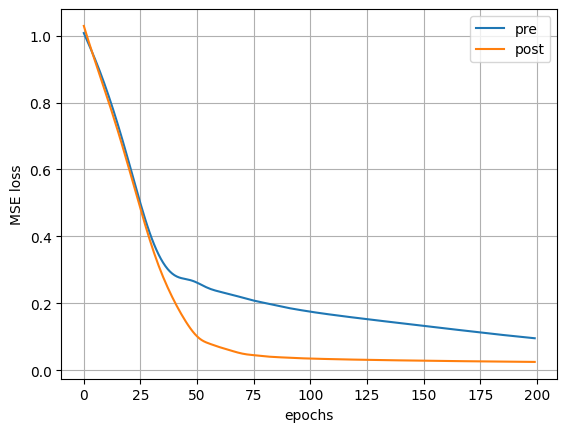

(None, None)

In [32]:

plt.plot(pre_test_losses, label="pre")
plt.plot(post_test_losses, label="post")
#plt.plot(test_loss, label="test")
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.grid(), plt.show()

### Loss comparison
Want to compare the loss, which is the difference between J_hat and J. The loss should be plotted against time, and a good results should be close to an constant.

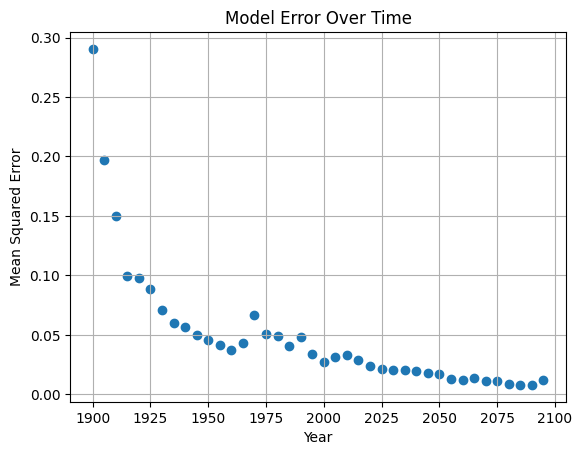

In [33]:
# De-transform the inputs and prepare test set
X_numpy = np.vstack((
    X_scaler_pre.inverse_transform(X_pre_1970_test.numpy()),
    X_scaler_post.inverse_transform(X_post_1970_test.numpy())
))
J_numpy = np.vstack((
    J_pre_1970_test.numpy(),
    J_post_1970_test.numpy()
))

# Combine all test sets to analyze over time
time_index = state_variables.get_loc('time')
errors = []
years = []

for year in range(1900, 2100, 5):
    # Find rows within this year bucket
    condition = (X_numpy[:, time_index] >= year) & (X_numpy[:, time_index] < year + 5)
    row_indices = np.where(condition)[0]

    if len(row_indices) == 0:
        continue

    # Split rows into pre and post 1970
    pre_mask = X_numpy[row_indices, time_index] < 1970
    post_mask = ~pre_mask

    error = 0
    count = 0

    if year < 1970:
        X_pre_rows = X_scaler_pre.transform(X_numpy[row_indices[pre_mask]])
        J_true_pre = J_numpy[row_indices[pre_mask]]
        with torch.no_grad():
            model_pre_1970.eval()
            J_pred_pre = model_pre_1970(torch.tensor(X_pre_rows, dtype=torch.float32)).numpy()
        error += np.sum((J_pred_pre - J_true_pre)**2)
        count += J_true_pre.shape[0]
    else:
        X_post_rows = X_scaler_post.transform(X_numpy[row_indices[post_mask]])
        J_true_post = J_numpy[row_indices[post_mask]]
        with torch.no_grad():
            model_post_1970.eval()
            J_pred_post = model_post_1970(torch.tensor(X_post_rows, dtype=torch.float32)).numpy()
        error += np.sum((J_pred_post - J_true_post)**2)
        count += J_true_post.shape[0]

    errors.append(error / count)
    years.append(year)

# Plot
plt.scatter(years, errors)
plt.xlabel('Year')
plt.ylabel('Mean Squared Error')
plt.title('Model Error Over Time')
plt.grid(True)
plt.show()


In [34]:
def nn_func(model_pre, model_post, world, k):
    """ 
    model: neural network model
    world: World3 object
    k: current iteration

    Returns
        J_hat
    """
    if world.time[k] < 1970:
        model = model_pre
        X_normalizer = X_scaler_pre
        J_normalizer = J_scaler_pre
    else:
        model = model_post
        X_normalizer = X_scaler_post
        J_normalizer = J_scaler_post
    model.eval()
    state = np.array([getattr(world, var)[k] for var in state_variables])
    state = X_normalizer.transform(state.reshape(1, -1))
    state = torch.tensor(state, dtype=torch.float32)
    with torch.no_grad():
        J_ = J_normalizer.inverse_transform(model.forward(state))
    return J_.item()

## Optimization

In [35]:
def loop0(world):
    world.redo_loop = True
    while world.redo_loop:  # unsorted updates at initialization only
        world.redo_loop = False
        world.loop0_population()
        world.loop0_capital()
        world.loop0_agriculture()
        world.loop0_pollution()
        world.loop0_resource()
    

def generate_fioac_control_values(world3, k):
    current_value = world3.fioac_control(k-1)
    lower_bound = max(current_value - 0.3, 0)   # Ensure the minimum value is at least 0
    upper_bound = min(current_value + 0.3, 1)   # Ensure that the maximum value is at least 0
    return np.linspace(lower_bound, upper_bound, 15)

def generate_isopc_control_values(world3, k):
    current_value = world3.isopc_control(k-1)
    lower_bound = max(current_value - 0.4, 0.01)   # Ensure the minimum value is at least 0,01 to avoid div with zero
    upper_bound = min(current_value + 0.4, 2)
    return np.linspace(lower_bound, upper_bound, 15)


def get_control(world3, k, steps, J_hat):
    """ 
    In:
        world3: pyworld3 simulation
        k: current iteration
        steps: how many steps to look ahead
        J_hat: Approximation of J function
    Returns:
        control: fioac control value, isopc control value
    """
    # _self._loopk_world3_fast(k_ - 1, k_, k_ - 1, k_)  # sorted updates
    n = world3.n
    steps = min(steps,n-k)
    
    best_J = -np.inf
    fioac_controls = generate_fioac_control_values(world3, k)
    isopc_controls = generate_isopc_control_values(world3, k)

    for val in fioac_controls:
        for val2 in isopc_controls:
            reward = 0
            world3.fioac_control = lambda _: val
            world3.isopc_control = lambda _: val2
            for k_new in range(k,k+steps):
                world3._loopk_world3_fast(k_new-1, k_new, k_new-1, k_new)
                if k_new != k+steps-1:
                    reward += reward_func(world3, k_new)
                else:
                    J_val = J_hat(world3, k_new)
                    reward += J_val
            if reward > best_J:
                best_J = reward
                fioac_val = val
                isopc_val = val2
    return fioac_val, isopc_val

def J_func(reward):
    """ 
    In:
        reward - numpy array: rewards for the simlation
    Out: 
        Array of J function values
    
    Computes the cumulative reward for each step onwards
    """
    iterations = reward.shape[0]
    J = np.zeros((iterations,1))
    J[iterations-1] = reward[iterations-1]
    for k in range(2,iterations+1):
        # J[n] is the reward at step n plus J[n+1]
        J[iterations-k] = reward[iterations-k] + J[iterations-k+1] 
    return J

In [36]:
world_control = World3(year_max=max_year)
world_control.set_world3_control()
world_control.init_world3_constants()
world_control.init_world3_variables()
world_control.set_world3_table_functions()
world_control.set_world3_delay_functions()

J_hat = lambda world, k: nn_func(model_pre_1970, model_post_1970, world, k)

def run_control(world):
    # loop0 first
    loop0(world)
    isopc_val = 1 # change?

    for k in tqdm(range(1,world.n)):
        if k % 10 == 0 and world.time[k] >= 1950:
            fioac_val, isopc_val = get_control(world, k, 20, J_hat)
            world.fioac_control = lambda _: fioac_val
            world.isopc_control = lambda _: isopc_val
            world.isopc_control_values[k] = isopc_val
            world._loopk_world3_fast(k -1, k, k-1, k)
        else:
            world._loopk_world3_fast(k -1, k, k-1, k)
            world.isopc_control_values[k] = isopc_val

run_control(world_control)
        

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [02:09<00:00,  3.09it/s]


### Results

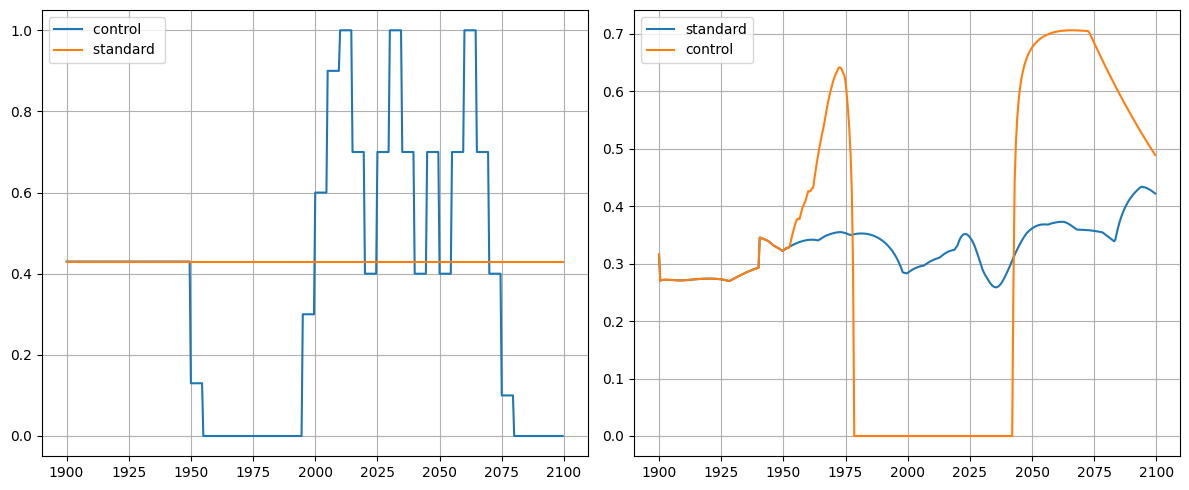

(None, <matplotlib.legend.Legend at 0x27d8528cf40>, None, None)

In [37]:
import matplotlib.pyplot as plt
start = 0
end = -1
plt.figure(figsize=(12, 5)), plt.subplot(1, 2, 1)
#plt.plot(world_reference.time[start:end], world_reference.fioac[start:end], label="standard fioac")
plt.plot(world_control.time[start:end], world_control.fioac[start:end], label="control ")
plt.plot(world_reference.time[start:end], world_reference.fioac[start:end], label="standard ")
#plt.plot(world_control.time[start:end], world_control.nr[start:end], label="control isopc")
plt.grid(), plt.legend(), plt.subplot(1, 2, 2)
plt.plot(world_reference.time[start:end], reward_func(world_reference)[start:end], label="standard")
plt.plot(world_control.time[start:end], reward_func(world_control)[start:end], label="control")
#plt.plot(world_reference.time[start:end], world_reference.ppol[start:end], label="standard")
#plt.plot(world_control.time[start:end], world_control.ppol[start:end], label="control")
plt.grid(), plt.legend(), plt.tight_layout(), plt.show()

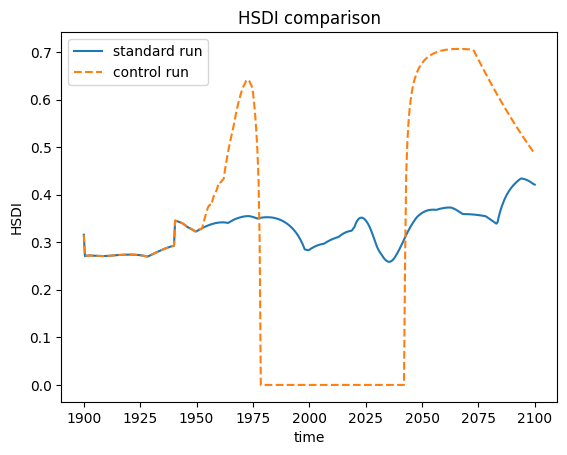

In [38]:
plt.plot(world_reference.time, reward_func(world_reference), label="standard run")
plt.plot(world_control.time, reward_func(world_control), label="control run", linestyle="--")
plt.legend()
plt.title("HSDI comparison")
plt.xlabel("time")
plt.ylabel("HSDI")
plt.show()

Plot of the rewards for the control run. Neural network for the control run and standard run starting from each state in the control run but with standard run instead.

In [39]:
def standard_run_from(world, k):
    initial_state = {}
    for var in state_variables:
        if var == "time":
            continue
        val = getattr(world, var)[k]
        initial_state[var+"i"] = val

    world_temp = World3(year_max=max_year, year_min=world.time[k])
    world_temp.set_world3_control()
    world_temp.init_world3_constants(**initial_state)
    world_temp.init_world3_variables()
    world_temp.set_world3_table_functions()
    world_temp.set_world3_delay_functions()
    world_temp.run_world3(fast=True)

    J_ = J_func(reward_func(world_temp)) # this can probably be more dynamic
    return J_[0] # only want the first value

In [40]:
time = world_control.time

J_control = J_func(reward_func(world_control)) # This can probably be more dynamic
J_standard = J_func(reward_func(world_reference))
nn_control = np.zeros((world_control.n,1))
nn_standard = np.zeros((world_reference.n,1))
standard_on_control = np.zeros((world_control.n,1))

for k in range(0, world_control.n):
    #standard_on_control[k] = standard_run_from(world_control, k)
    nn_control[k] = J_hat(world_control, k)
    nn_standard[k] = J_hat(world_reference, k)

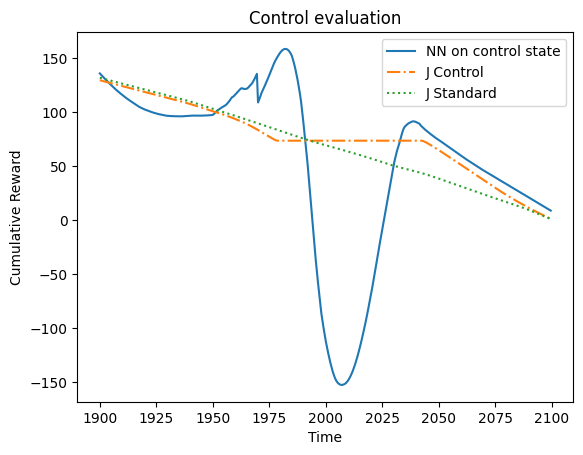

In [41]:
start = 0
end = -1

plt.plot(time[start:end], nn_control[start:end], label="NN on control state", linestyle='-')
#plt.plot(time[start:end], standard_on_control[start:end], label="Standard from control state", linestyle='--')
# plt.plot(time[start:end], nn_standard[start:end], label="NN on Standard", linestyle=':', marker='^')
plt.plot(time[start:end], J_control[start:end], label="J Control", linestyle='-.')
plt.plot(time[start:end], J_standard[start:end], label="J Standard", linestyle=':')

plt.title("Control evaluation")
plt.ylabel("Cumulative Reward")
plt.xlabel("Time")
plt.legend()
plt.show()


*Comments* the control does perform better, but it performs rather bad at the end. Might be because he training data there is bad. The control also needs a very long look ahead to do anything useful

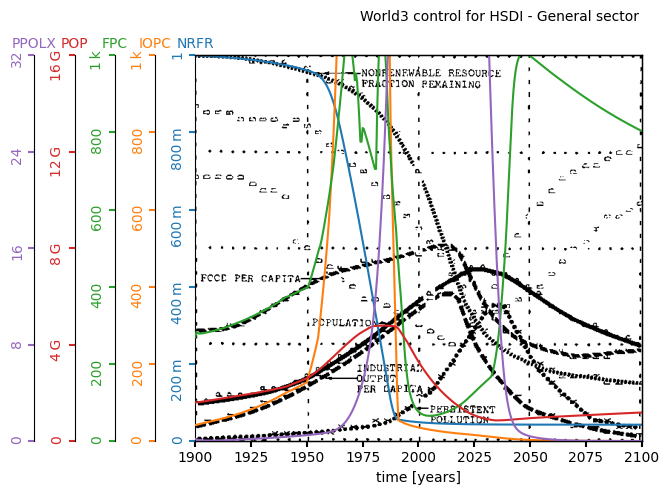

In [42]:
from pyworld3.utils import plot_world_variables

plot_world_variables(
    world_control.time,
    [world_control.nrfr, world_control.iopc, world_control.fpc, world_control.pop, world_control.ppolx],
    ["NRFR", "IOPC", "FPC", "POP", "PPOLX"],
    [[0, 1], [0, 1e3], [0, 1e3], [0, 16e9], [0, 32]],
    img_background="./img/fig7-7.png",
    figsize=(7, 5),
    title="World3 control for HSDI - General sector",
)
plt.show()